In [1]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

vergely_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/vergely2022/vergely22_extinction_density_resol_010pc.h5'
from dustmaps.vergely2022 import Vergely2022Query

In [2]:
distance = np.linspace(0, 1000, 150)

l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 250)
l, b, d = np.meshgrid(l_, b_, distance, indexing = 'ij')

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

In [3]:
coords.shape

(200, 250, 150)

NameError: name 'CA_meta' is not defined

In [4]:
vergelyquery = Vergely2022Query(map_fname = vergely_path)
vergely = vergelyquery(coords)
print(vergely.shape)

shape: (601, 601, 161)
(601, 601, 161)
(200, 250, 150)


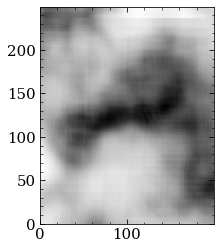

In [5]:
plt.imshow(np.sum(vergely, axis = 2).T, origin = 'lower', cmap = 'binary')

In [6]:
def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[l_ind, b_ind, :])

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[l_ind, b_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline))
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

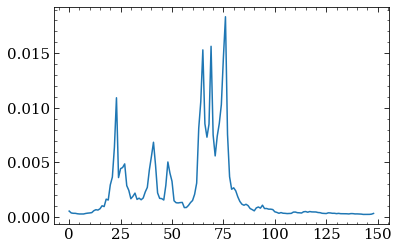

In [7]:
l_ind, b_ind = find_nearest(161, -7.5)

d_ind = find_nearest_dist(1000)[0]

los = vergely[l_ind, b_ind, :d_ind]
plt.plot(los)

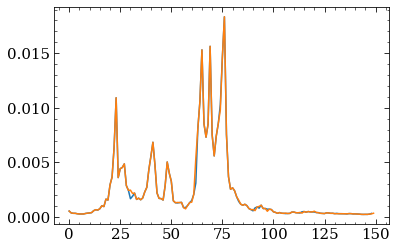

In [8]:
los_query = vergelyquery(SkyCoord(l=161*u.deg, b=-7.5*u.deg, distance=distance[distance <= 1000]*u.pc, frame='galactic'))
plt.plot(los)
plt.plot(los_query)

In [9]:
item = np.loadtxt('data.txt', delimiter=',')
item[: ,np.array([3,4]).astype(int)]

array([[1.56654e+00, 2.21000e-03],
       [1.62625e+00, 3.31000e-03],
       [1.41484e+00, 1.89000e-03],
       ...,
       [1.48627e+00, 7.20000e-03],
       [1.75084e+00, 3.59000e-03],
       [2.04049e+00, 5.25000e-03]])

In [10]:
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/20230420_CAResiduals/'
CA_meta = Table(fits.open(CAresdir + 'CA_meta.fits')[1].data)
# CA_meta['GTOMO_AV'] = item[3]
# CA_meta['GTOMO_AVERR'] = item[4]

tabfile = '/uufs/chpc.utah.edu/common/home/sdss/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits'
stars = Table.read(tabfile, hdu = 1)

stars_addon = stars['APOGEE_ID', 'SFD_EBV', 'SNR', 'ASPCAPFLAG', 'STARFLAG', 'ASPCAP_CHI2']
CA_meta['DIST'] = 1000 / CA_meta['GAIAEDR3_PARALLAX']

CA_meta = join(CA_meta, stars_addon, keys = 'APOGEE_ID', join_type = 'left',)

CA_meta = CA_meta[(CA_meta['DIST'] > 250) & (CA_meta['DIST'] < 800)]

starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [12]:
dustmaps_inds = np.zeros((len(CA_meta), 3)).astype(int)

for i in range(len(CA_meta)):
    star = CA_meta[i]

    try:
        l_ind, b_ind = find_nearest(star['GLON'], star['GLAT'])
        d_ind = find_nearest_dist(star['DIST'])
        dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind))
    except:
        dustmaps_inds[i, :] = 0

/tmp/ipykernel_3054497/4246754492.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dustmaps_inds[i, :] = np.array((l_ind, b_ind, d_ind))
